# Simple Model Training with Darts Library

In [39]:
#work with darts library to create a time series forecast
import darts
import pandas as pd
import wapi
from darts.models.forecasting.rnn_model import RNNModel
from darts import TimeSeries
from tqdm import tqdm



In [41]:
def assemble_dataframe(time_start, time_end, config_file_path='../apiconfig.ini'):

    curve_names = [
            "pro ch spv mwh/h cet min15 a",
            "pro ch spv mwh/h cet min15 n",
            "pro it spv mwh/h cet min15 a",
            "pro fr spv mwh/h cet min15 a",
            "pro de spv mwh/h cet min15 a",
            "pro at spv mwh/h cet min15 a",
            "cap ch spv mw cet min15 a",
            "tt ch grimsel test °c cet h s",
            "tt ch adelboden test °c cet h s",
            "tt ch geneve test °c cet h s",
            "tt ch davos test °c cet h s",
            "tt ch engelberg test °c cet h s",
            "tt ch bern test °c cet h s",
            "tt ch lugano test °c cet h s",
            "tt ch zurich test °c cet h s",
            "tt ch samedan test °c cet h s",
        ]

    session = wapi.Session(config_file=config_file_path)
    ch_total_prod_curve = session.get_curve(name=curve_names[0])
    ts = ch_total_prod_curve.get_data(data_from= time_start, data_to=time_end, frequency='h', function ="AVERAGE")
    series = []
    for curve in tqdm(curve_names):
        next_curve = session.get_curve(name=curve)
        print(curve)
        ts = next_curve.get_data(data_from=time_start, data_to=time_end, frequency='h', function ="AVERAGE")
        series.append(ts.to_pandas())
    return pd.concat(series,axis=1)


In [68]:
data = assemble_dataframe('2015-01-01', '2020-12-05')


  0%|          | 0/16 [00:00<?, ?it/s]

pro ch spv mwh/h cet min15 a


c:\Users\thoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\wapi\util.py:135: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return res.asfreq(self._map_freq(self.frequency))
  6%|▋         | 1/16 [00:04<01:03,  4.23s/it]

pro ch spv mwh/h cet min15 n


 12%|█▎        | 2/16 [00:08<00:59,  4.28s/it]

pro it spv mwh/h cet min15 a


 19%|█▉        | 3/16 [00:12<00:55,  4.30s/it]

pro fr spv mwh/h cet min15 a


 25%|██▌       | 4/16 [00:17<00:54,  4.54s/it]

pro de spv mwh/h cet min15 a


 31%|███▏      | 5/16 [00:21<00:48,  4.41s/it]

pro at spv mwh/h cet min15 a


 38%|███▊      | 6/16 [00:27<00:46,  4.66s/it]

cap ch spv mw cet min15 a


 44%|████▍     | 7/16 [00:31<00:40,  4.50s/it]

tt ch grimsel test °c cet h s


 50%|█████     | 8/16 [00:33<00:29,  3.72s/it]

tt ch adelboden test °c cet h s


 56%|█████▋    | 9/16 [00:35<00:22,  3.20s/it]

tt ch geneve test °c cet h s


 62%|██████▎   | 10/16 [00:38<00:18,  3.15s/it]

tt ch davos test °c cet h s


 69%|██████▉   | 11/16 [00:40<00:14,  2.81s/it]

tt ch engelberg test °c cet h s


 75%|███████▌  | 12/16 [00:42<00:09,  2.46s/it]

tt ch bern test °c cet h s


 81%|████████▏ | 13/16 [00:44<00:07,  2.41s/it]

tt ch lugano test °c cet h s


 88%|████████▊ | 14/16 [00:46<00:04,  2.31s/it]

tt ch zurich test °c cet h s


 94%|█████████▍| 15/16 [00:48<00:02,  2.15s/it]

tt ch samedan test °c cet h s


100%|██████████| 16/16 [00:50<00:00,  3.14s/it]


In [69]:
pd_dataframe = data

In [70]:
#make the index as a column called timestep
pd_dataframe['timestamp'] = pd_dataframe.index
pd_dataframe = pd_dataframe.reset_index(drop=True)

In [71]:

pd_dataframe['timestamp'] = pd.to_datetime(pd_dataframe.timestamp).dt.tz_localize(None)

In [72]:

#freq = pd.infer_freq(pd_dataframe['timestamp'])

#find the gaps in the timestep data column where the frequency is not hourly
pd_dataframe['time_diff'] = pd_dataframe['timestamp'].diff()
indexes_not_hourly = pd_dataframe[pd_dataframe["time_diff"] != pd.Timedelta('0 days 01:00:00')]
indexes = indexes_not_hourly.index.tolist()

shifted_df = pd_dataframe.copy()

print(indexes)


[0, 2090, 7130, 10826, 16034, 19562, 24770, 28298, 33506, 37202, 42242, 45938, 50978]


In [73]:

for i in range(len(indexes)-1):
    index = indexes[i]
    end_index = indexes [i+1] if i+1 < len(indexes) else len(pd_dataframe)

    end_index -= 1
    print(end_index)

    if pd_dataframe.loc[index]["timestamp"].month == 3:


        #shift from start_index to end_index the datetime by 1 hour and delete the where the time_diff is 0 days 00:00:00

        shifted_df.loc[index:end_index, 'timestamp'] = pd_dataframe.loc[index:end_index, 'timestamp'] - pd.Timedelta('1 hours')




2089
7129
10825
16033
19561
24769
28297
33505
37201
42241
45937
50977


In [75]:
#select the columns that are float or int
shifted_df_numeric = shifted_df.select_dtypes(include=['float64', 'int64'])

shifted_df

,pro ch spv mwh/h cet min15 a,pro ch spv mwh/h cet min15 n,pro it spv mwh/h cet min15 a,pro fr spv mwh/h cet min15 a,pro de spv mwh/h cet min15 a,pro at spv mwh/h cet min15 a,cap ch spv mw cet min15 a,tt ch grimsel test °c cet h s,tt ch adelboden test °c cet h s,tt ch geneve test °c cet h s,tt ch davos test °c cet h s,tt ch engelberg test °c cet h s,tt ch bern test °c cet h s,tt ch lugano test °c cet h s,tt ch zurich test °c cet h s,tt ch samedan test °c cet h s,timestamp,time_diff
0,0.0,0.000000,1.0,0.000000,0.0,0.0,992.000000,-12.8,-7.8,-1.1,-12.6,-6.5,-6.2,-2.1,-6.0,-12.8,2015-01-01 00:00:00,NaT
1,0.0,0.000000,1.0,0.000000,0.0,0.0,992.000000,-12.9,-7.8,-1.4,-12.9,-6.7,-6.4,-2.1,-6.0,-12.9,2015-01-01 01:00:00,0 days 01:00:00
2,0.0,0.000000,1.0,0.000000,0.0,0.0,992.000000,-12.8,-7.9,-1.6,-12.9,-7.1,-6.5,-1.9,-6.0,-12.8,2015-01-01 02:00:00,0 days 01:00:00
3,0.0,0.000000,1.0,0.000000,0.0,0.0,992.000000,-12.9,-8.0,-2.0,-12.9,-7.6,-6.5,-1.6,-6.0,-12.9,2015-01-01 03:00:00,0 days 01:00:00
4,0.0,0.000000,1.0,0.000000,0.0,0.0,992.000000,-12.5,-8.2,-2.4,-12.7,-7.8,-6.9,-1.4,-6.3,-12.5,2015-01-01 04:00:00,0 days 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51955,0.0,0.008839,0.0,0.559107,0.0,0.0,2727.290323,-6.7,-8.1,0.5,-3.7,-7.7,-0.3,0.0,-0.5,-6.7,2020-12-04 19:00:00,0 days 01:00:00
51956,0.0,0.000158,0.0,0.559107,0.0,0.0,2727.290323,-6.3,-8.3,0.3,-3.6,-7.4,-0.8,0.1,-0.5,-6.3,2020-12-04 20:00:00,0 days 01:00:00
51957,0.0,0.000000,0.0,0.559107,0.0,0.0,2727.290323,-6.1,-8.5,0.3,-3.3,-7.4,-1.5,0.2,-0.8,-6.1,2020-12-04 21:00:00,0 days 01:00:00
51958,0.0,0.000000,0.0,0.559107,0.0,0.0,2727.290323,-5.8,-8.9,0.5,-3.3,-7.7,-1.3,0.3,-1.5,-5.8,2020-12-04 22:00:00,0 days 01:00:00


In [76]:
shifted_df_numeric

,pro ch spv mwh/h cet min15 a,pro ch spv mwh/h cet min15 n,pro it spv mwh/h cet min15 a,pro fr spv mwh/h cet min15 a,pro de spv mwh/h cet min15 a,pro at spv mwh/h cet min15 a,cap ch spv mw cet min15 a,tt ch grimsel test °c cet h s,tt ch adelboden test °c cet h s,tt ch geneve test °c cet h s,tt ch davos test °c cet h s,tt ch engelberg test °c cet h s,tt ch bern test °c cet h s,tt ch lugano test °c cet h s,tt ch zurich test °c cet h s,tt ch samedan test °c cet h s
0,0.0,0.000000,1.0,0.000000,0.0,0.0,992.000000,-12.8,-7.8,-1.1,-12.6,-6.5,-6.2,-2.1,-6.0,-12.8
1,0.0,0.000000,1.0,0.000000,0.0,0.0,992.000000,-12.9,-7.8,-1.4,-12.9,-6.7,-6.4,-2.1,-6.0,-12.9
2,0.0,0.000000,1.0,0.000000,0.0,0.0,992.000000,-12.8,-7.9,-1.6,-12.9,-7.1,-6.5,-1.9,-6.0,-12.8
3,0.0,0.000000,1.0,0.000000,0.0,0.0,992.000000,-12.9,-8.0,-2.0,-12.9,-7.6,-6.5,-1.6,-6.0,-12.9
4,0.0,0.000000,1.0,0.000000,0.0,0.0,992.000000,-12.5,-8.2,-2.4,-12.7,-7.8,-6.9,-1.4,-6.3,-12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51955,0.0,0.008839,0.0,0.559107,0.0,0.0,2727.290323,-6.7,-8.1,0.5,-3.7,-7.7,-0.3,0.0,-0.5,-6.7
51956,0.0,0.000158,0.0,0.559107,0.0,0.0,2727.290323,-6.3,-8.3,0.3,-3.6,-7.4,-0.8,0.1,-0.5,-6.3
51957,0.0,0.000000,0.0,0.559107,0.0,0.0,2727.290323,-6.1,-8.5,0.3,-3.3,-7.4,-1.5,0.2,-0.8,-6.1
51958,0.0,0.000000,0.0,0.559107,0.0,0.0,2727.290323,-5.8,-8.9,0.5,-3.3,-7.7,-1.3,0.3,-1.5,-5.8


In [77]:
series = TimeSeries.from_dataframe(shifted_df, "timestamp", shifted_df_numeric.columns, fill_missing_dates=True, freq='H')

c:\Users\thoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\darts\timeseries.py:4736: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)


In [79]:
series

<TimeSeries (DataArray) (timestamp: 51960, component: 16, sample: 1)> Size: 7MB
array([[[  0. ],
        [  0. ],
        [  1. ],
        ...,
        [ -2.1],
        [ -6. ],
        [-12.8]],

       [[  0. ],
        [  0. ],
        [  1. ],
        ...,
        [ -2.1],
        [ -6. ],
        [-12.9]],

       [[  0. ],
        [  0. ],
        [  1. ],
        ...,
...
        ...,
        [  0.2],
        [ -0.8],
        [ -6.1]],

       [[  0. ],
        [  0. ],
        [  0. ],
        ...,
        [  0.3],
        [ -1.5],
        [ -5.8]],

       [[  0. ],
        [  0. ],
        [  0. ],
        ...,
        [  0.6],
        [ -1.5],
        [ -5.4]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 416kB 2015-01-01 ... 2020-12-04T23:...
  * component  (component) object 128B 'pro ch spv mwh/h cet min15 a' ... 'tt...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [78]:
shifted_df.dtypes

pro ch spv mwh/h cet min15 a               float64
pro ch spv mwh/h cet min15 n               float64
pro it spv mwh/h cet min15 a               float64
pro fr spv mwh/h cet min15 a               float64
pro de spv mwh/h cet min15 a               float64
pro at spv mwh/h cet min15 a               float64
cap ch spv mw cet min15 a                  float64
tt ch grimsel test °c cet h s              float64
tt ch adelboden test °c cet h s            float64
tt ch geneve test °c cet h s               float64
tt ch davos test °c cet h s                float64
tt ch engelberg test °c cet h s            float64
tt ch bern test °c cet h s                 float64
tt ch lugano test °c cet h s               float64
tt ch zurich test °c cet h s               float64
tt ch samedan test °c cet h s              float64
timestamp                           datetime64[ns]
time_diff                          timedelta64[ns]
dtype: object

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 265 K 
4 | V             | Linear           | 257   
---------------------------------------------------
265 K     Trainable params
0         Non-trainable params
265 K     Total params
1.062     Total estimated model params size (MB)


Epoch 3:  47%|████▋     | 197/422 [00:24<00:27,  8.07it/s, train_loss=1.28e+5]

c:\Users\thoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.50it/s]


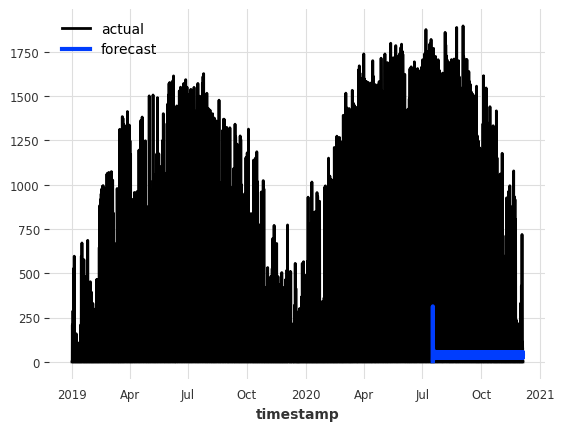

In [22]:
#select the training and validation 20% is validation and last points
train, val = series.split_after(0.8)

#types = ["LSTM", "GRU", "RNN"] available models
choosen_model = "LSTM"
chunk_length = 24
hidden_dim = 256
n_epochs = 100

#rnn model 
model = RNNModel(model=choosen_model,input_chunk_length= chunk_length, hidden_dim = 256 ,n_rnn_layers=1, n_epochs=n_epochs, random_state=0) 

#fit the model


model.fit(train)
prediction = model.predict(len(val))


import matplotlib.pyplot as plt
series.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()



Number of components is larger than 10 (16). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger than 10 (16). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


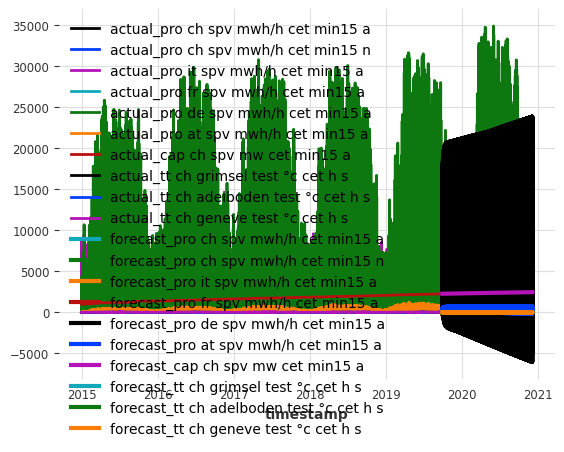

In [81]:
train, val = series.split_after(0.8)

from darts.models import LinearRegressionModel

model = LinearRegressionModel(lags = 24)
model.fit(train)
prediction = model.predict(len(val))

series.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()


<Axes: xlabel='timestamp'>

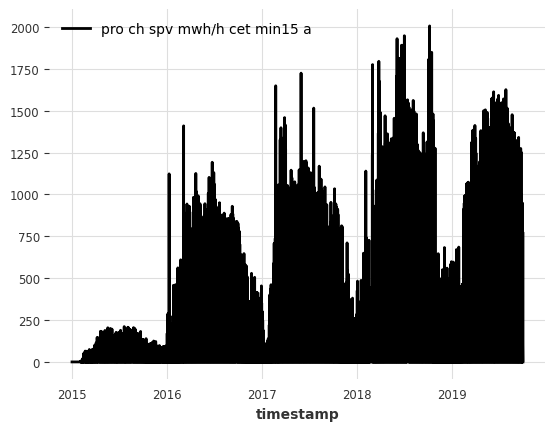

In [99]:
train.univariate_component(0).plot()
train_target, val_target = train.univariate_component(0), val.univariate_component(0)
train_coev = train.drop_columns("pro ch spv mwh/h cet min15 a"")




In [80]:
train, val = series.split_after(0.8)

from darts.models import XGBModel

xgm_model = XGBModel(lags = 24*30)
xgm_model.fit(train)
prediction = xgm_model.predict(len(val))

series.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()

KeyboardInterrupt: 

In [ ]:
train